# Учебный проект №7
# Исследование бизнес-показателей

Постановка задачи: исследуя данные данные о клиентском трафике и покупках, затратах на рекламу в разных источниках, выявить наиболее вероятные факторы, влекущие убыточность компании (развивает приложение Procrastinate Pro+).
<br>Исходные данные:
1. Информация о пользователях, привлечённых с 1 мая по 27 октября 2019 года.
    - лог сервера с данными о посещениях;
    - выгрузка покупок за этот период.
2. Рекламные расходы.

## Загрузка данных и подготовка их к анализу

In [1]:
# блок загрузки библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings

# скрываем предупреждения
warnings.filterwarnings('ignore')

In [2]:
# загружаем данные локально или с сервера
try:
    visits = pd.read_csv('visits_info_short.csv')
except:
    visits = pd.read_csv('network path hidden')
try:
    orders = pd.read_csv('orders_info_short.csv')
except:
    orders = pd.read_csv('network path hidden') 
try:
    costs = pd.read_csv('costs_info_short.csv')
except:
    costs = pd.read_csv('network path hidden') 

In [3]:
# знакомство с информацией о визитах
display(visits.info())
print('Количество дубликатов:', visits.duplicated().sum(), sep=' ')
visits.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

Количество дубликатов: 0


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
# приводим все столбцы в нижний регистр, убираем пробелы из названий
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns=({'user id':'user_id', 'session start':'session_start', 'session end':'session_end'}))

# преобразуем тип данных для даты в DT
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Пропусков и дублей в данных нет, все значения "non-null". Переходим к следующему ДФ

In [5]:
# знакомство с информацией о покупках
display(orders.info())
print('Количество дубликатов:', orders.duplicated().sum(), sep=' ')
orders.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

Количество дубликатов: 0


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
# приводим все столбцы в нижний регистр, убираем пробелы из названий
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns=({'user id':'user_id', 'event dt':'event_dt'}))

# преобразуем тип данных для даты в DT
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [7]:
# оценим возможные аномалии
orders.revenue.describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

Данные о покупках сосредоточены вокруг значения 4.99, при этом есть какое-то количество бОльших значений, но максимальное - вполне адекватное 49.99 Принимаем решение, что аномальных значений в таблице нет.

Пропусков и дублей в данных нет, все значения "non-null". Переходим к следующему ДФ

In [8]:
# знакомство с информацией о затратах
display(costs.info())
print('Количество дубликатов:', costs.duplicated().sum(), sep=' ')
costs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Количество дубликатов: 0


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [9]:
# приводим все столбцы в нижний регистр, пробелов нет
costs.columns = costs.columns.str.lower()

# преобразуем тип данных для даты в DT
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Данные готовы, имена столбцов приведены к нижнему регистру, пробелы убраны, дубликатов нет, аномальные значения не обнаружены.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

In [12]:
# задаём функции для расчёта и анализа LTV, ROI, удержания и конверсии
#(функции любезно предоставлены авторами курса)

##### `get_profiles()` — для создания профилей пользователей #####
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

##### `get_retention()` — для подсчёта Retention Rate #####

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

##### `get_conversion()` — для подсчёта конверсии #####

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

##### `get_ltv()` — для подсчёта LTV и ROI #####

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
########## функции для построения графиков ###########

##### `filter_data()` — для сглаживания данных #####

def filter_data(df, window=7):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

##### `plot_retention()` — для построения графика Retention Rate #####

def plot_retention(retention, retention_history, horizon, window=7):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

##### `plot_conversion()` — для построения графика конверсии #####

def plot_conversion(conversion, conversion_history, horizon, window=7):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))
    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

##### `plot_ltv_roi` — для визуализации LTV и ROI #####

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей

In [14]:
# для составления профилей вызываем функцию get_profiles()
events = None # данных по событиям у нас нет, нужно "занулить" аргумент, передаваемый функции
profiles = get_profiles(visits, orders, events, costs)
display(profiles.info())
print('Минимальная (самая ранняя) дата привлечения пользователей: {}'.format(profiles['dt'].min()))
print('Максимальная (самая поздняя) дата привлечения пользователей: {}'.format(profiles['dt'].max()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

Минимальная (самая ранняя) дата привлечения пользователей: 2019-05-01
Максимальная (самая поздняя) дата привлечения пользователей: 2019-10-27


Итак, на входе имеем данные о 150 тысячах уникальных пользователей из разных стран и на разных устройствах, привлечённых в приложение с 1 мая 2019 года по 27 октября 2019 года

### Определение стран, из которых пользователи приходят в приложение, выявление страны, на которую приходится больше всего платящих пользователей

Далее проведём анализ стран, откуда приходят пользователи, их устройств, а также источники рекламы. Кроме того, по каждому фактору необходимо выявить лидера по доле платящих клиентов.

In [15]:
# так как анализ предполагает схожие операции с таблицей profiles, создадим функцию
def profiles_analysis(profiles, factor):
# из готовых профайлов группировкой получим неоходимые данные в нужном разрезе
    profiles_factor = profiles.groupby(factor).agg(
        {'user_id': 'sum'}).rename(columns={'user_id': 'user_count'})

# выделяем столбец с платящими
    profiles_factor['user_payer'] = profiles.query(
        'payer == True').groupby(factor).agg({'user_id': 'sum'})

# считаем долю пользователей
    profiles_factor['total_user_share'] = round(
        profiles_factor['user_count'] / profiles_factor['user_count'].sum(), 3)

# вычисляем долю платящих
    profiles_factor['payer_share'] = round(
        profiles_factor['user_payer'] / profiles_factor['user_count'], 3)

    return profiles_factor.sort_values(by='payer_share', ascending=False)

# и функцию визуализации результата


def plot_profiles_analysis(profiles_factor, factor_txt):
    ax1 = plt.subplot(1, 2, 1)
    profiles_factor['payer_share'].plot(
        grid=True, ax=ax1, kind='bar', figsize=(10, 6)
    )
    plt.xlabel(factor_txt)
    plt.xticks(rotation=65)
    plt.title('Доля платящих клиентов')

    # второй график
    ax2 = plt.subplot(1, 2, 2)
    profiles_factor['user_count'].plot(
        ax=ax2, kind='pie', autopct='%1.2f%%', fontsize=8, ylabel=''
    )
    plt.title('Доли пользователей ({})'.format(factor_txt))
    plt.tight_layout()
    plt.show()

,user_count,user_payer,total_user_share,payer_share
region,,,,
United States,49950116036552088,3459661042730579,0.667,0.069
Germany,7500868654706280,307355129560276,0.100,0.041
UK,8730498320190994,349889653913745,0.117,0.040
France,8721079260394761,334450276705236,0.116,0.038


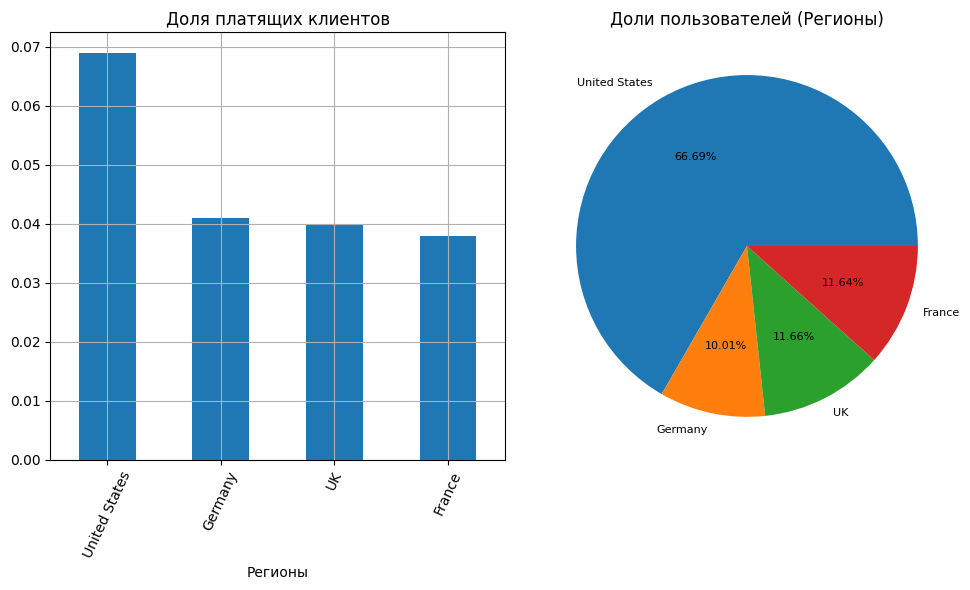

In [16]:
# итак, 1 фактор - страны
res = profiles_analysis(profiles, factor=['region'])
display(res)
plot_profiles_analysis(res, 'Регионы')


Пользователи приходят из регионов: США, Франция, Германия и Великобритания. Абсолютный лидер, как по общему количеству пришедших пользователей, так и по доле платящих пользователей - США (доля платящих 7%, доля пользователей из этого региона 67%). В остальных странах доля платящих клиентов около 4%.

### Устройства, которыми пользуются клиенты, выявление наиболее предпочитаемых устройств платящих пользователей

,user_count,user_payer,total_user_share,payer_share
device,,,,
Mac,15046944881398228,949156264807867,0.201,0.063
iPhone,27194994461895148,1690691160021225,0.363,0.062
Android,17459821335133222,1038670039029691,0.233,0.059
PC,15200801593417964,772838639051053,0.203,0.051


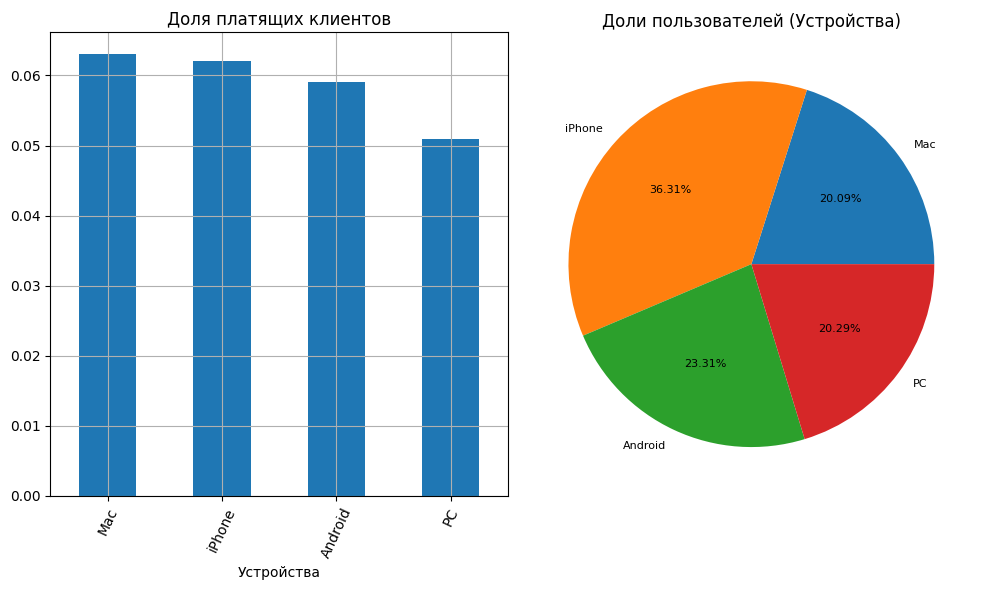

In [17]:
res = profiles_analysis(profiles, factor=['device'])
display(res)
plot_profiles_analysis(res, 'Устройства')

Логи зафиксировали пользователей на разных устройствах: Mac, iPhone, Android и PC. Лидер, как по общему количеству пришедших пользователей - iPhone (доля пользователей 36.31%). Лидеры по платящим пользователям - Mac (6.3%) и iPhone (6,2%)

### Анализ рекламных источников привлечения. Определение каналов, из которых пришло больше всего платящих пользователей

,user_count,user_payer,total_user_share,payer_share
channel,,,,
FaceBoom,14606558389460580,1801874552179937,0.195,0.123
AdNonSense,1959480189776244,216793551404131,0.026,0.111
lambdaMediaAds,1037457796359666,110134651958277,0.014,0.106
TipTop,9708289783241686,932087707241321,0.130,0.096
RocketSuperAds,2231345012998483,177287644887685,0.030,0.079
WahooNetBanner,4255663316033473,237706119732975,0.057,0.056
YRabbit,2143810696485552,84375025470346,0.029,0.039
MediaTornado,2217083852497856,79568747062729,0.030,0.036
LeapBob,4288996831818403,127922430917669,0.057,0.030


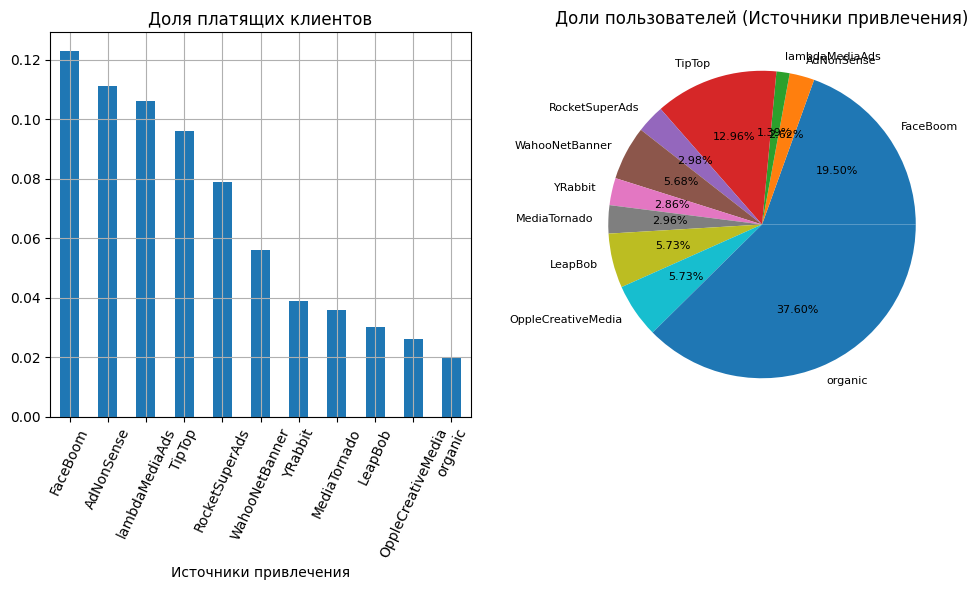

In [18]:
res = profiles_analysis(profiles, factor=['channel'])
display(res)
plot_profiles_analysis(res, 'Источники привлечения')

Пользователей "приводят" совершенно разные источники: в таблице 10 наименований рекламных источников + органические пользователи, пришедшие сами собой. Больше всего платный трафик генерирует источник FaceBoom, он же лидирует по общему числу пользователей (исключая самую многочисленную группу бесплатных "органиков").

## Маркетинг

### Подсчёт общей суммы расходов на маркетинг и структуры этих расходов по источникам

In [19]:
# работаем с ДФ costs, сумма всех трат
print('Общая сумма расходов на маркетинг за весь период по имеющимся данным {:.2f} USD'.format(costs['costs'].sum()))

Общая сумма расходов на маркетинг за весь период по имеющимся данным 105497.30 USD


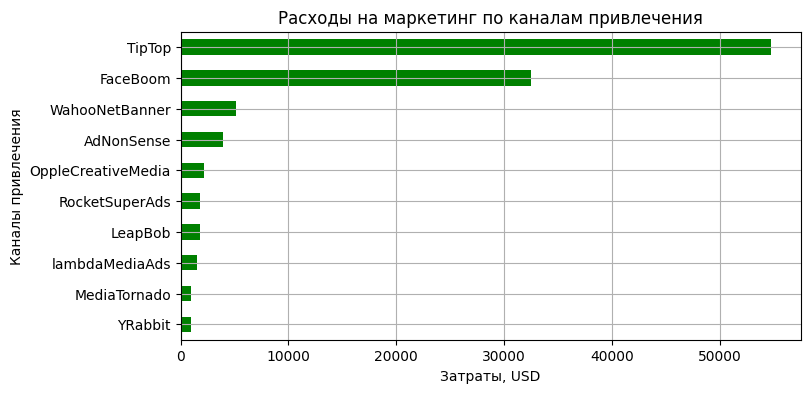

In [20]:
# группируем по каналу и считаем сумму затрат
costs.groupby('channel')['costs'].agg('sum').sort_values().plot(
        grid=True
        ,kind='barh'
        ,color='green'
        ,figsize=(8, 4)
        )
plt.xlabel('Затраты, USD')
plt.ylabel('Каналы привлечения')
plt.title('Расходы на маркетинг по каналам привлечения')
plt.show()

При общих затратах на маркетинг чуть больше 105 тыс. USD, больше половины бюджета отдано каналу TipTop (больше 50 тыс., т.е. более 50% всего бюджета), при этом данный канал не является лидером по привлекаемому трафику платящих клиентов. Лидер (FaceBoom) на втором месте по расходу бюджета: на его долю пришлось около 30% процентов трат. Остальные каналы поделили между собой оставшиеся 20% бюджета, соответственно, каждому досталось не более 5%.

### Динамика изменения расходов во времени (по неделям и месяцам) по каждому каналу привлечения

In [21]:
# для недельных и месячных графиков добавим соответствующие столбцы - номер месяца и номер недели
costs['dt_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month

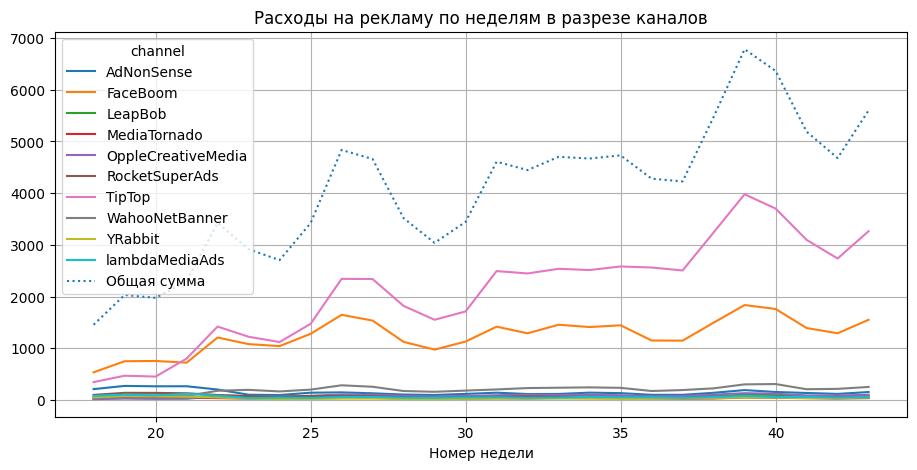

In [22]:
# график № раз недели
plt.figure(figsize=(11, 5))
ax1 = plt.subplot()
(
costs.pivot_table(
    index='channel'
    , columns='dt_week'
    , values='costs'
    , aggfunc='sum'
    )
    .T
    .plot(grid=True, ax=ax1)
)
plt.xticks(rotation=0)

# также добавим линию суммарных затрат
(
costs.groupby('dt_week')
     .agg({'costs':'sum'})
     .rename(columns={'costs':'Общая сумма'})
     .plot(grid=True, ax=ax1, linestyle='dotted')
)

plt.xlabel('Номер недели')
plt.title('Расходы на рекламу по неделям в разрезе каналов')
plt.show()

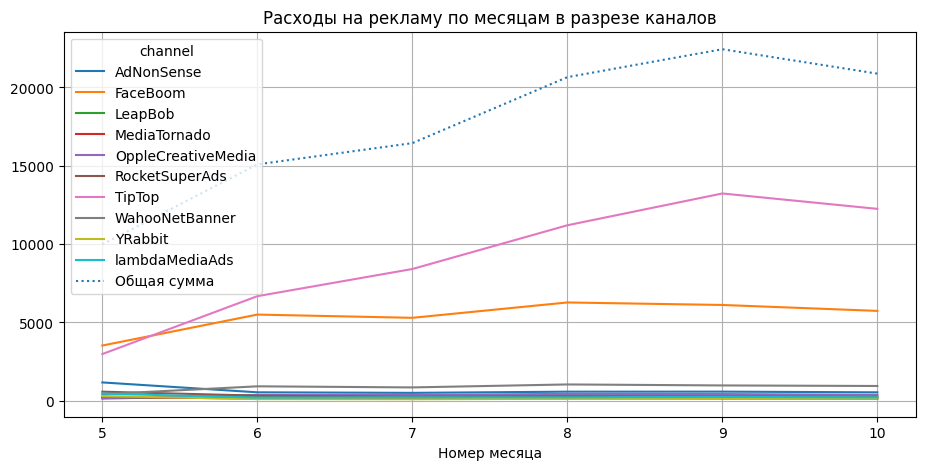

In [23]:
# график № двас - месяцы
plt.figure(figsize=(11, 5))
ax1 = plt.subplot()
costs.pivot_table(index='channel', columns='dt_month', values='costs', aggfunc='sum').T.plot(
    grid=True
    ,ax=ax1
    )
plt.xticks(rotation=0)
# также добавим линию суммарных затрат
costs.groupby('dt_month').agg({'costs':'sum'}).rename(columns={'costs':'Общая сумма'}).plot(
    grid=True
    ,ax=ax1
    ,linestyle='dotted'
    )
plt.xlabel('Номер месяца')
plt.title('Расходы на рекламу по месяцам в разрезе каналов')
plt.show()

Графики динамики расходов на рекламу в разбивке по каналам привлечения показывают стремительный рост расходов на 2 канала: TipTop и FaceBoom (недельные расходы в пике по TipTop достигали 4000 USD, в месяц - больше 12000 USD, по FaceBoom до 1800 и 6000, соответственно). Это те самые каналы, которые мы выделили в прошлом пункте. Причём динамика роста расходов на TipTop существенно выше, по сравнению с FaceBoom - маркетологи компании делали на этот канал привлечения ставку. Расходы на остальные каналы - стабильны, динамики изменения расходов по ним нет (в пределах 400 USD в неделю и до 1000 USD в месяц).<br>
За счёт роста расходов на эти два канала существенный рост показывают и суммарные затраты, т.к. оба источника имеют значительный вес в структуре расходов.

### Cредняя стоимость привлечения одного пользователя (CAC) из каждого источника

In [24]:
# из профайлов возьмём среднюю CAC, сгруппированную по каналу
(
profiles
    .groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


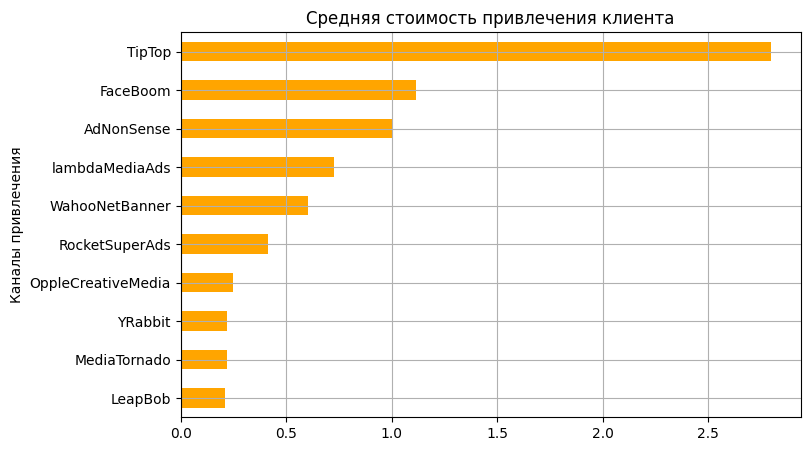

In [25]:
# визуализация таблицы
# исключаем строку с каналом "органик", т.к. ожидаемо, что стоимость привлечения 0
(
profiles
    .query('channel != "organic"')
    .groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values(by='acquisition_cost', ascending=True)
    .plot(
        kind='barh'
        ,color='orange'
        ,grid=True
        ,title='Средняя стоимость привлечения клиента'
        ,xlabel='Каналы привлечения'
        ,figsize=(8,5)
        ,legend=False
        )
);

Средняя стоимость привлечения заметно отличается от канала к каналу. Это зависит, как от самих затрат, так и от количества привлечённых по этому каналу клиентов. В лидерах вновь оказываются два канала: TipTop и FaceBoom. Причём первый лидирует с заметным отрывом, это говорит о том, что при росте вложений, который отмечался выше в исследовании, отдача, т.е. приход новых платящих пользователей по этому каналу не увеличивается (это мы также видели по отчёту выше).

## Оценка окупаемости рекламы

Исходные данные: на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения

Для начала посмотрим, а есть ли вообще убыточность в компании?

In [26]:
print('Общая сумма доходов от клиентов за весь период по имеющимся данным {:.2f} USD'.format(orders['revenue'].sum()))

Общая сумма доходов от клиентов за весь период по имеющимся данным 215962.88 USD


Сумма дохода в 2 раза превышает показатель затрат на маркетинг, полученный в пунктке 4.1: 105497.30 USD<br><br>
Но нельзя забывать, что часть этого дохода принесли "органические" пользователи, т.е. которые пришли самостоятельно, вне проводимых рекламных кампаний. Для чистоты анализа этих пользователей необходимо исключить из анализа.

In [27]:
# вычищаем "органиков" из профайлов
profiles = profiles.query('channel != "organic"')
# заново оцениваем доходы
not_org_list = profiles['user_id'].to_list()
print('Общая сумма доходов от клиентов за весь период по имеющимся данным {:.2f} USD'.format(orders.query('user_id in @not_org_list')['revenue'].sum()))

Общая сумма доходов от клиентов за весь период по имеющимся данным 169335.65 USD


Заново оценим общую динамику расходов на рекламу и доходы

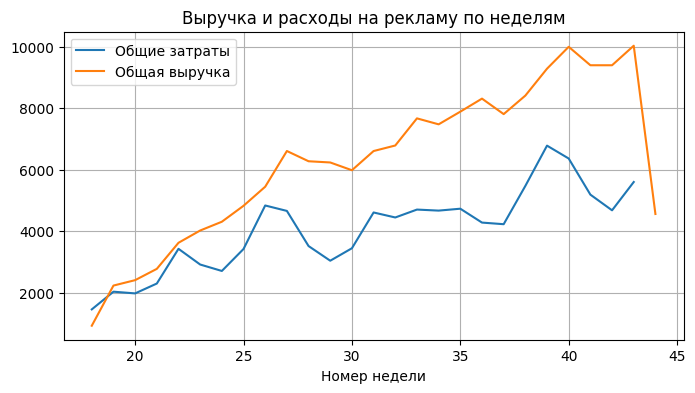

In [28]:
#добавим столбец с неделями
orders['dt_week'] = pd.to_datetime(orders['event_dt']).dt.isocalendar().week

plt.figure(figsize=(8, 4))
ax1 = plt.subplot()
(
costs.groupby('dt_week')
     .agg({'costs':'sum'})
     .rename(columns={'costs':'Общие затраты'})
     .plot(grid=True, ax=ax1)
)
(
orders.query('user_id in @not_org_list').groupby('dt_week')
     .agg({'revenue':'sum'})
     .rename(columns={'revenue':'Общая выручка'})
     .plot(grid=True, ax=ax1)
)

plt.xlabel('Номер недели')
plt.title('Выручка и расходы на рекламу по неделям')
plt.show()

Выручка растёт стабильно и на всем диапазоне недельных значений превышает расходы на рекламу (резкий обрыв в конце графика связан с одной "лишней" неделей в файле покупок (вероятно, эти данные неполные). Необходимо проанализировать, соответствует ли этот рост выручки и соотношение затрат и выручки поставленным задачам в бизнес-плане.

In [29]:
# задаём дату и горизонт анализа
# горизон задаём 14 дней, чтобы соответствовать задаче из бизнес-плана - окупаемость за 2 недели
observ_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Общая окупаемость рекламы (графики LTV и ROI, динамика LTV, CAC и ROI)

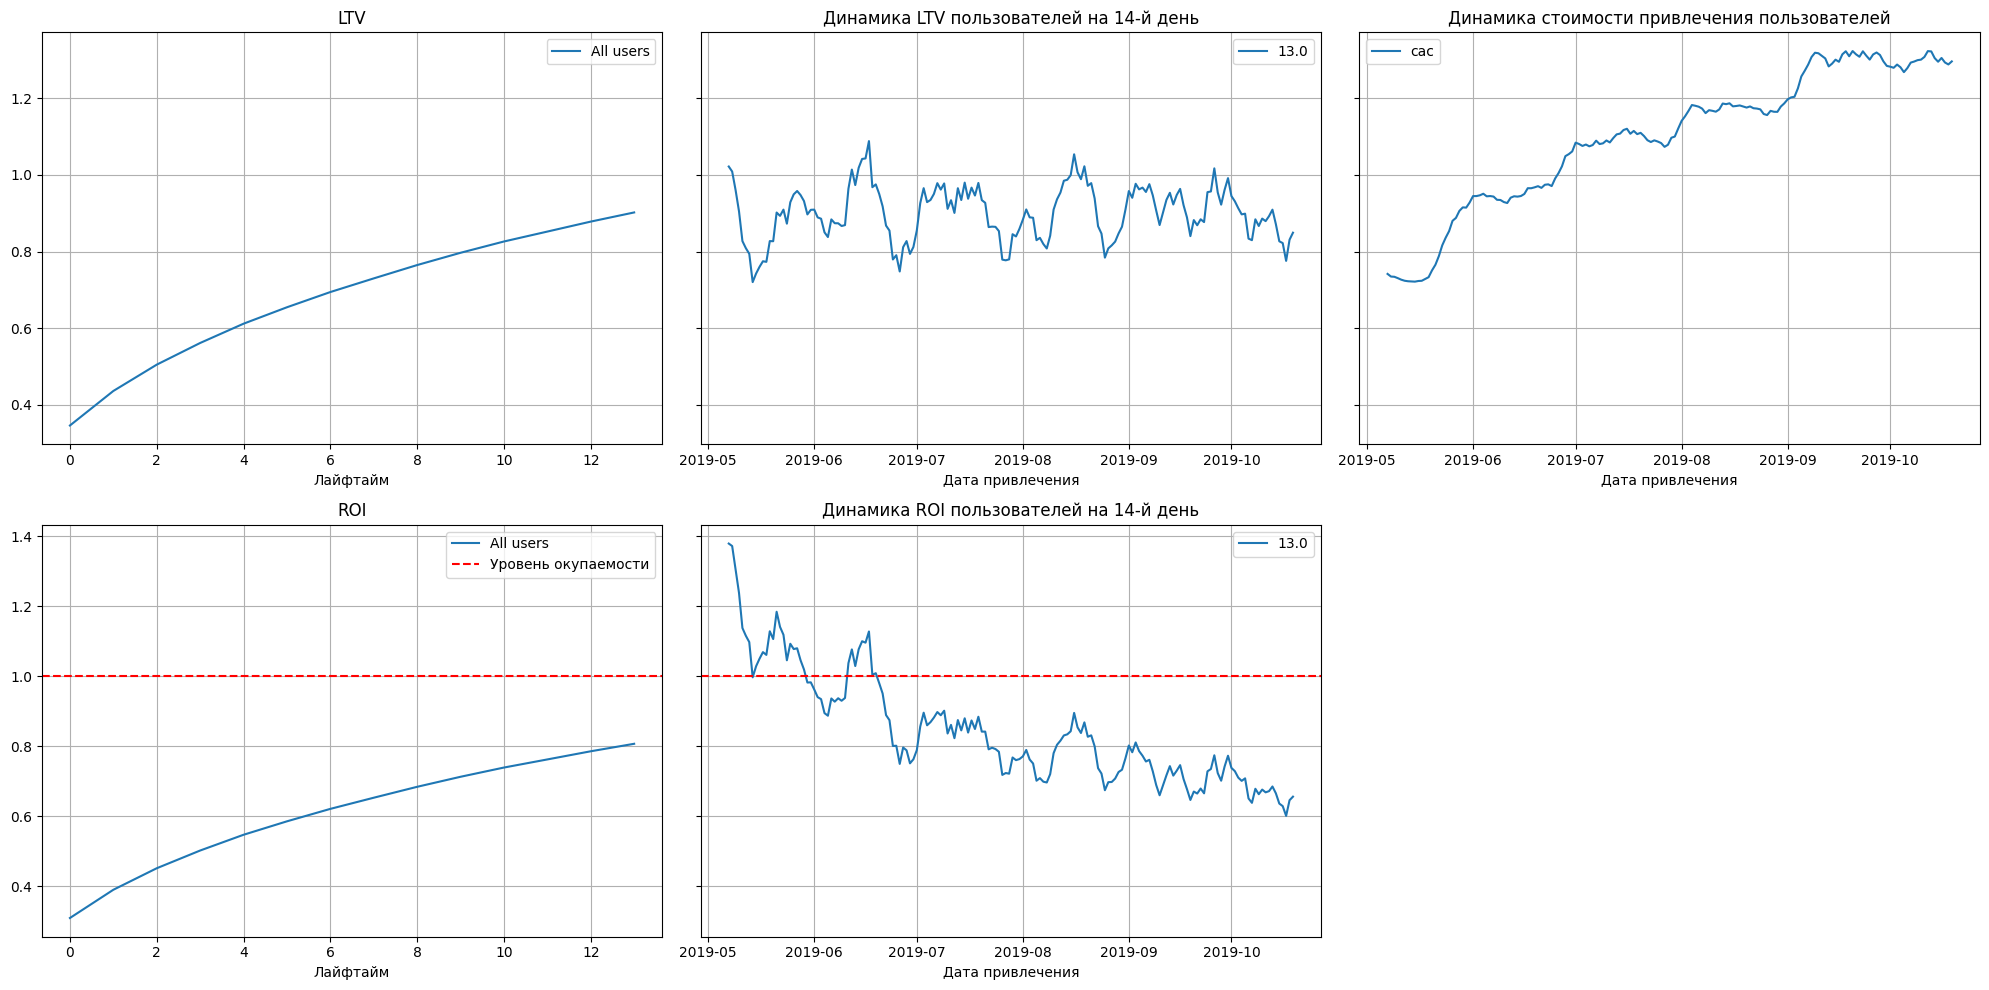

In [30]:
# вызываем ~Вия~ get_ltv
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles
    , orders
    , observ_date
    , horizon_days
)

# передаём данные функции отрисовки
plot_ltv_roi(
    ltv_grouped
    , ltv_in_time
    , roi_grouped
    , roi_in_time
    , horizon_days
    , window=7
)

Анализируя графики можно сделать выводы:
- реклама не окупается, ROI не достигает 1 к концу 14 дней, несмотря на рост LTV;
- за весь рассматриваемый период стоимость привлечения клиентов неуклонно растёт - CAC имеет почти постоянный положительный наклон, это говорит о постоянном росте рекламного бюджета (подтверждение этому мы это видели в выше в исследовании);
- график динамики ROI, соответственно, показывает от корогорты к когорте падение дохода на пользователя. И если в июне 2019 года показатель был выше единицы, то в июле 2019 года стоимость привлечения пользователя перестала отбиваться приносимым доходом.

### Конверсия и удержание пользователей и динамика изменения этих показателей

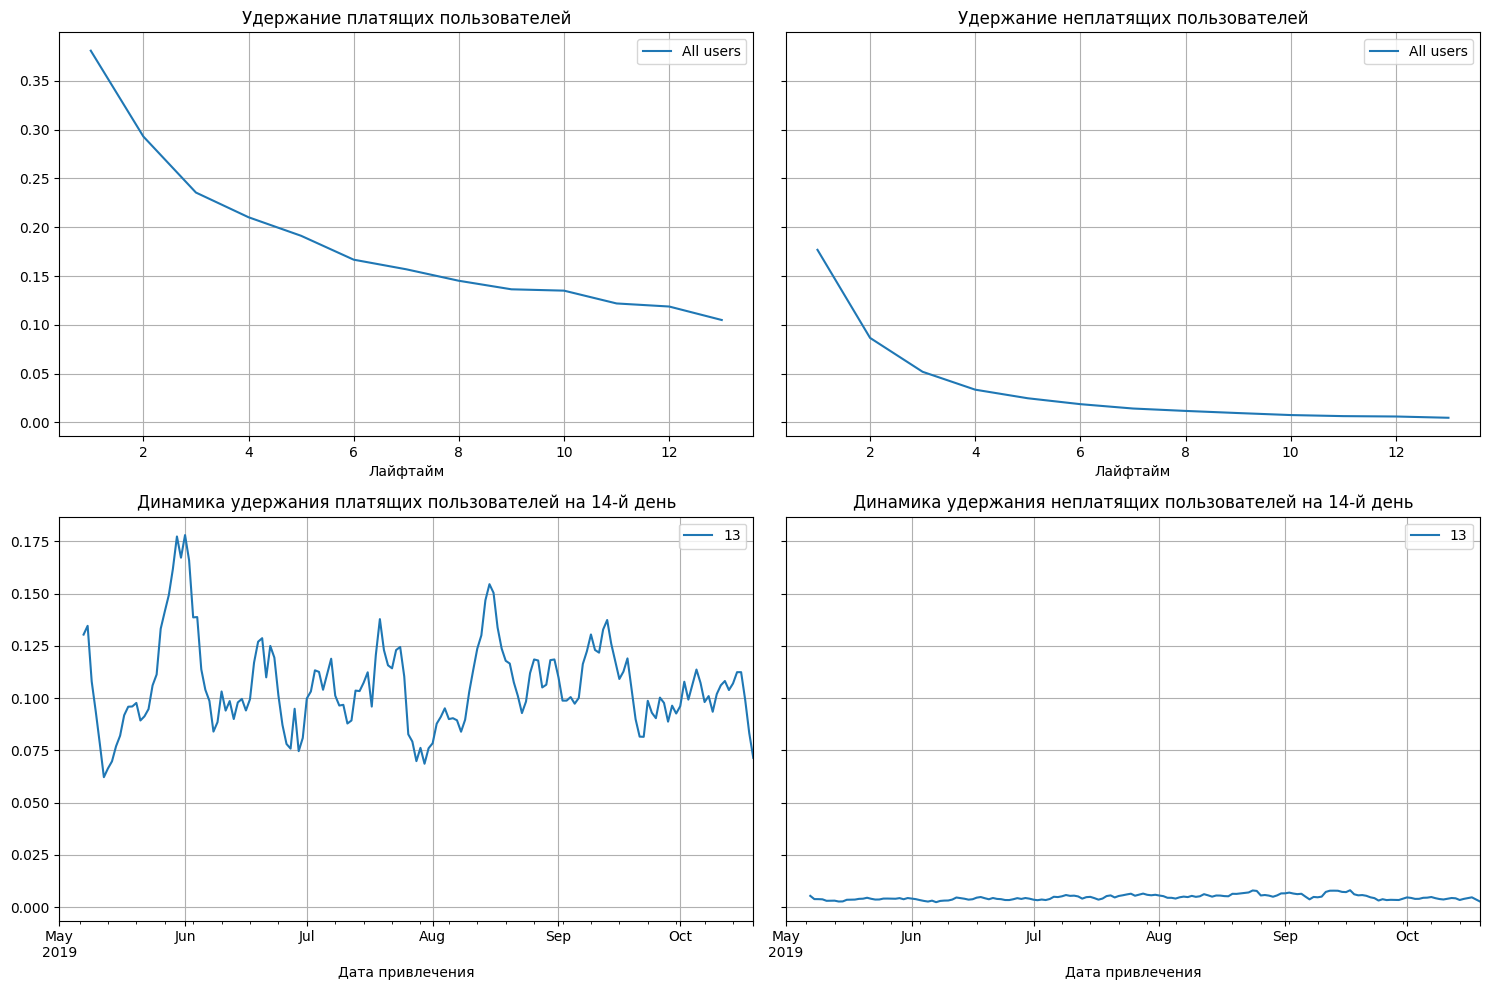

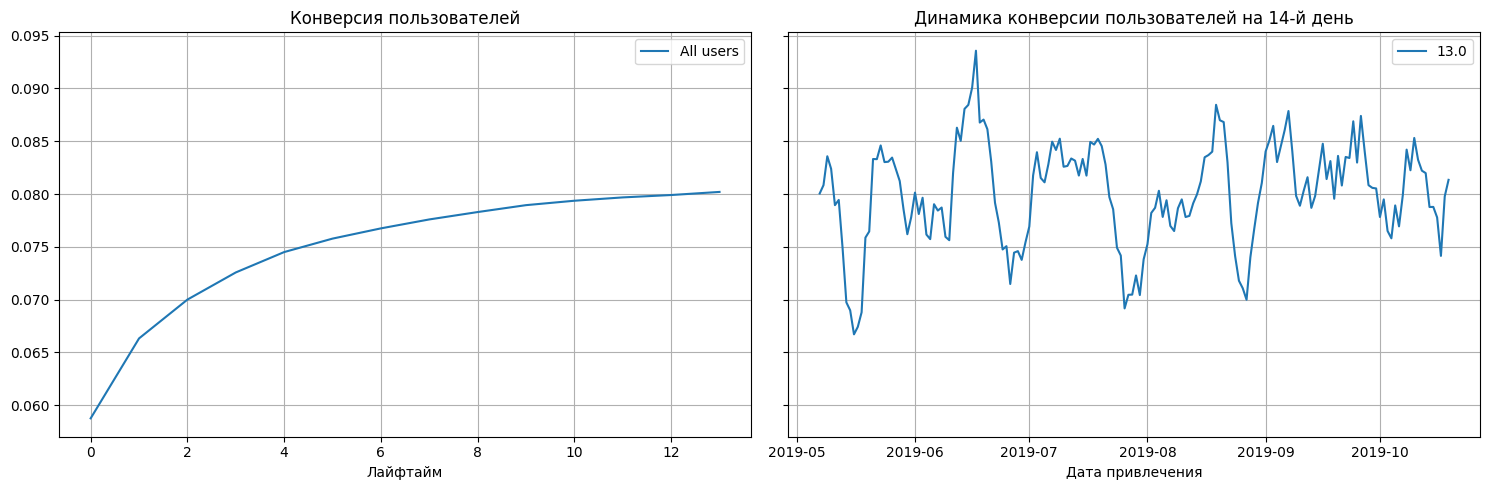

In [31]:
# вызываем get_retention и get_conversion

retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles, visits, observ_date, horizon_days
)
coversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles, orders, observ_date, horizon_days
)

# передаём данные функции отрисовки
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

- динамика удержания и конверсии без разбивки по факторам - довольно стабильные
- кривая удержания плавно снижается с 35% до 10% к 14 дню лайфтайма - довольно хороший показатель
- удержание платящих пользователей заметно выше неплатящих - это закономерно, платящие пользователи более заинтересованы в продолжении "взоимодействия" изначально (есть, что терять)
- кривая конверсии плавно растёт до значения примерно 8%

### Анализ окупаемости рекламы с разбивкой по устройствам

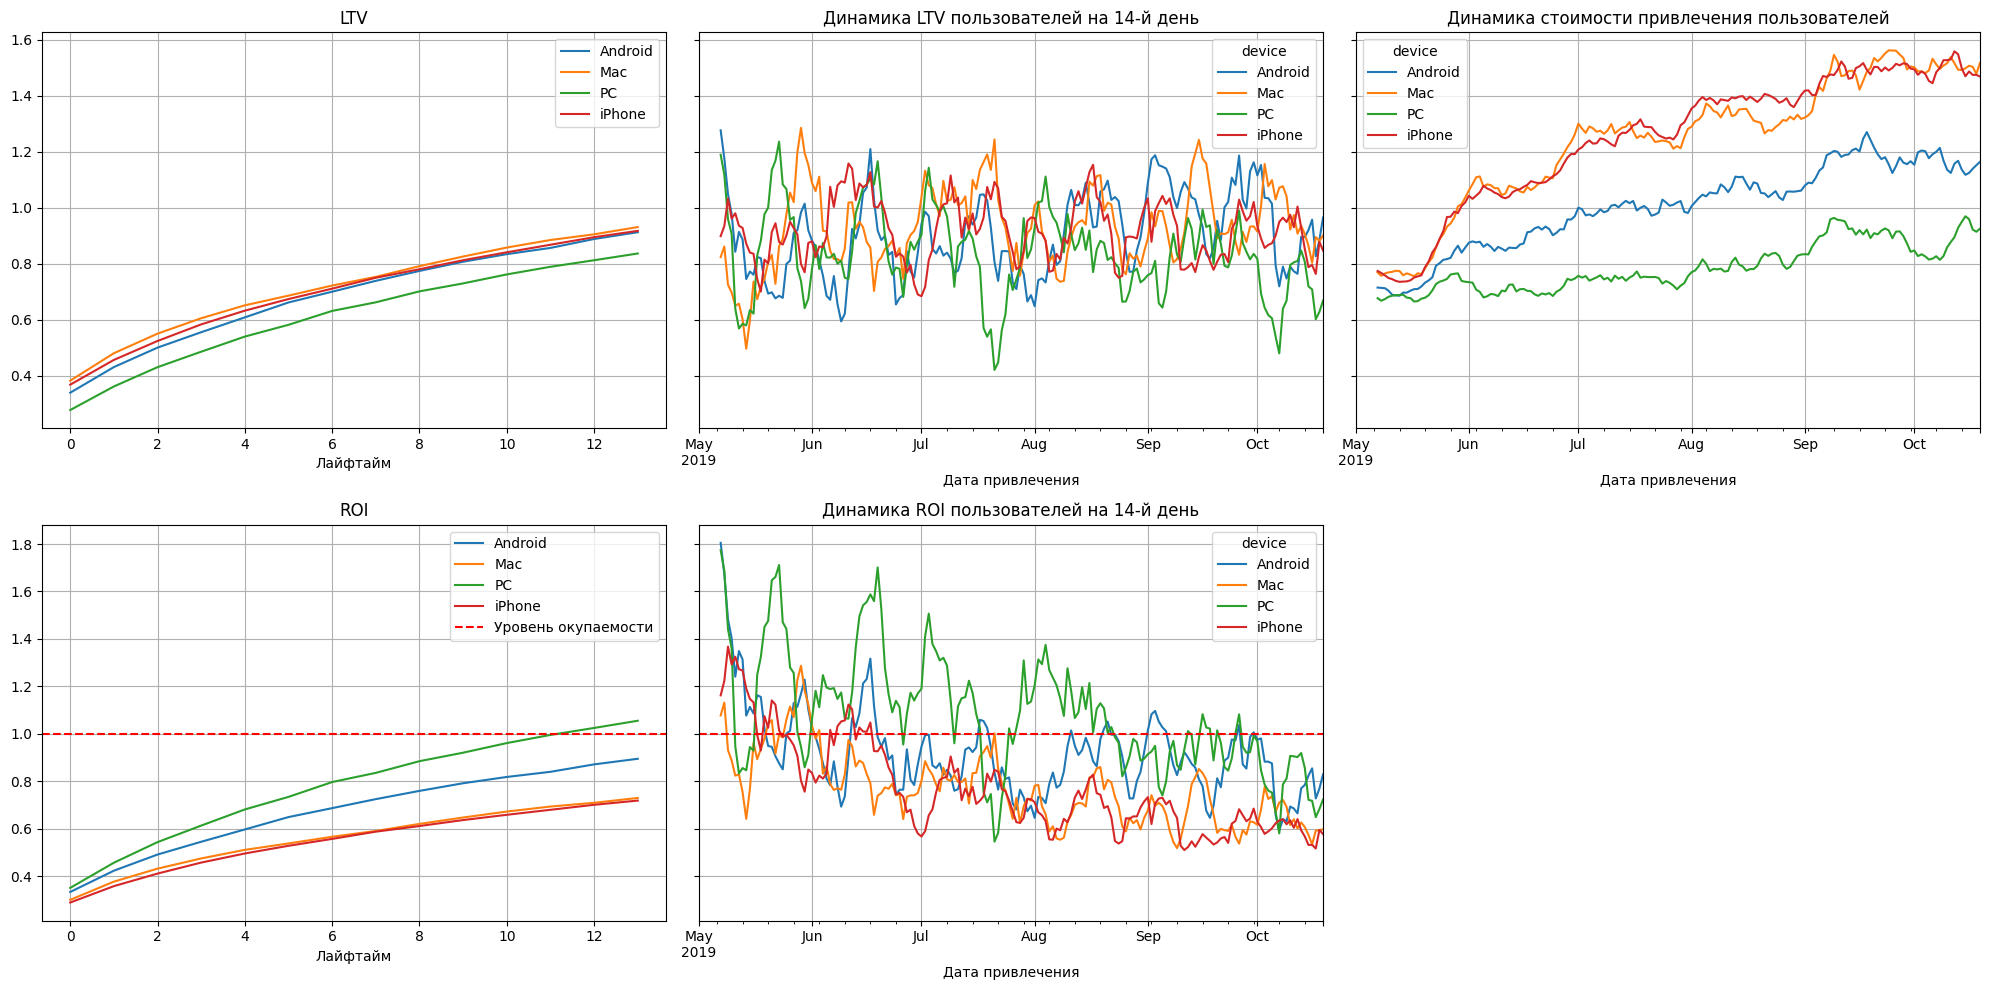

In [32]:
# вызываем знакомые функции с доп.параметром dimensions=['device']

ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles
    ,orders
    , observ_date
    , horizon_days
    , dimensions=['device']
)

# передаём данные функции отрисовки
plot_ltv_roi(
    ltv_grouped
    , ltv_in_time
    , roi_grouped
    , roi_in_time
    , horizon_days
    , window=7
)

Оценим, как на окупаемость влияет устройство, с которого первый раз зашёл пользователь:
- график "пожизненного дохода" - LTV - по всем устройства стабильно растёт к 14 дню, некоторое отставание от остальных показывает только платформа PC;
- динамика LTV на 14-ый день стабильна по всем платформам, также более глубокие просадки видны на PC;
- график динамики стоимости привлечения (CAC) подтверждает ранее описанную картину - постоянный рост средних расходов по привлечению новых клиентов. Самые быстрорастущие - iPhone и Mac, средняя позиция - Android, наименьший прирост CAC у PC;
- по графику ROI видим, что к 11 дню вложения в рекламу окупаются только по PC, новые пользователи остальных платформ - не отбивают затраты на привлечение;
- динамика ROI на 14 день лайфтайма показывает нисходящую динамику. В среднем с каждой новой когортой, новые пользователи на 14-ый лайфтайм приносят всё меньше и меньше дохода. Это также подтверждает ранее описанную картину - с июля 2019 года по большинству платформ пользователи новых когорт становятся убыточными. Причём, если новые пользователи с первой покупой в начале октября ещё держатся вокруг точки окупаемости на платформах Android и PC, то такие же пользователи в конце октября уже убыточны в 14 день.

### Анализ окупаемости рекламы с разбивкой по странам

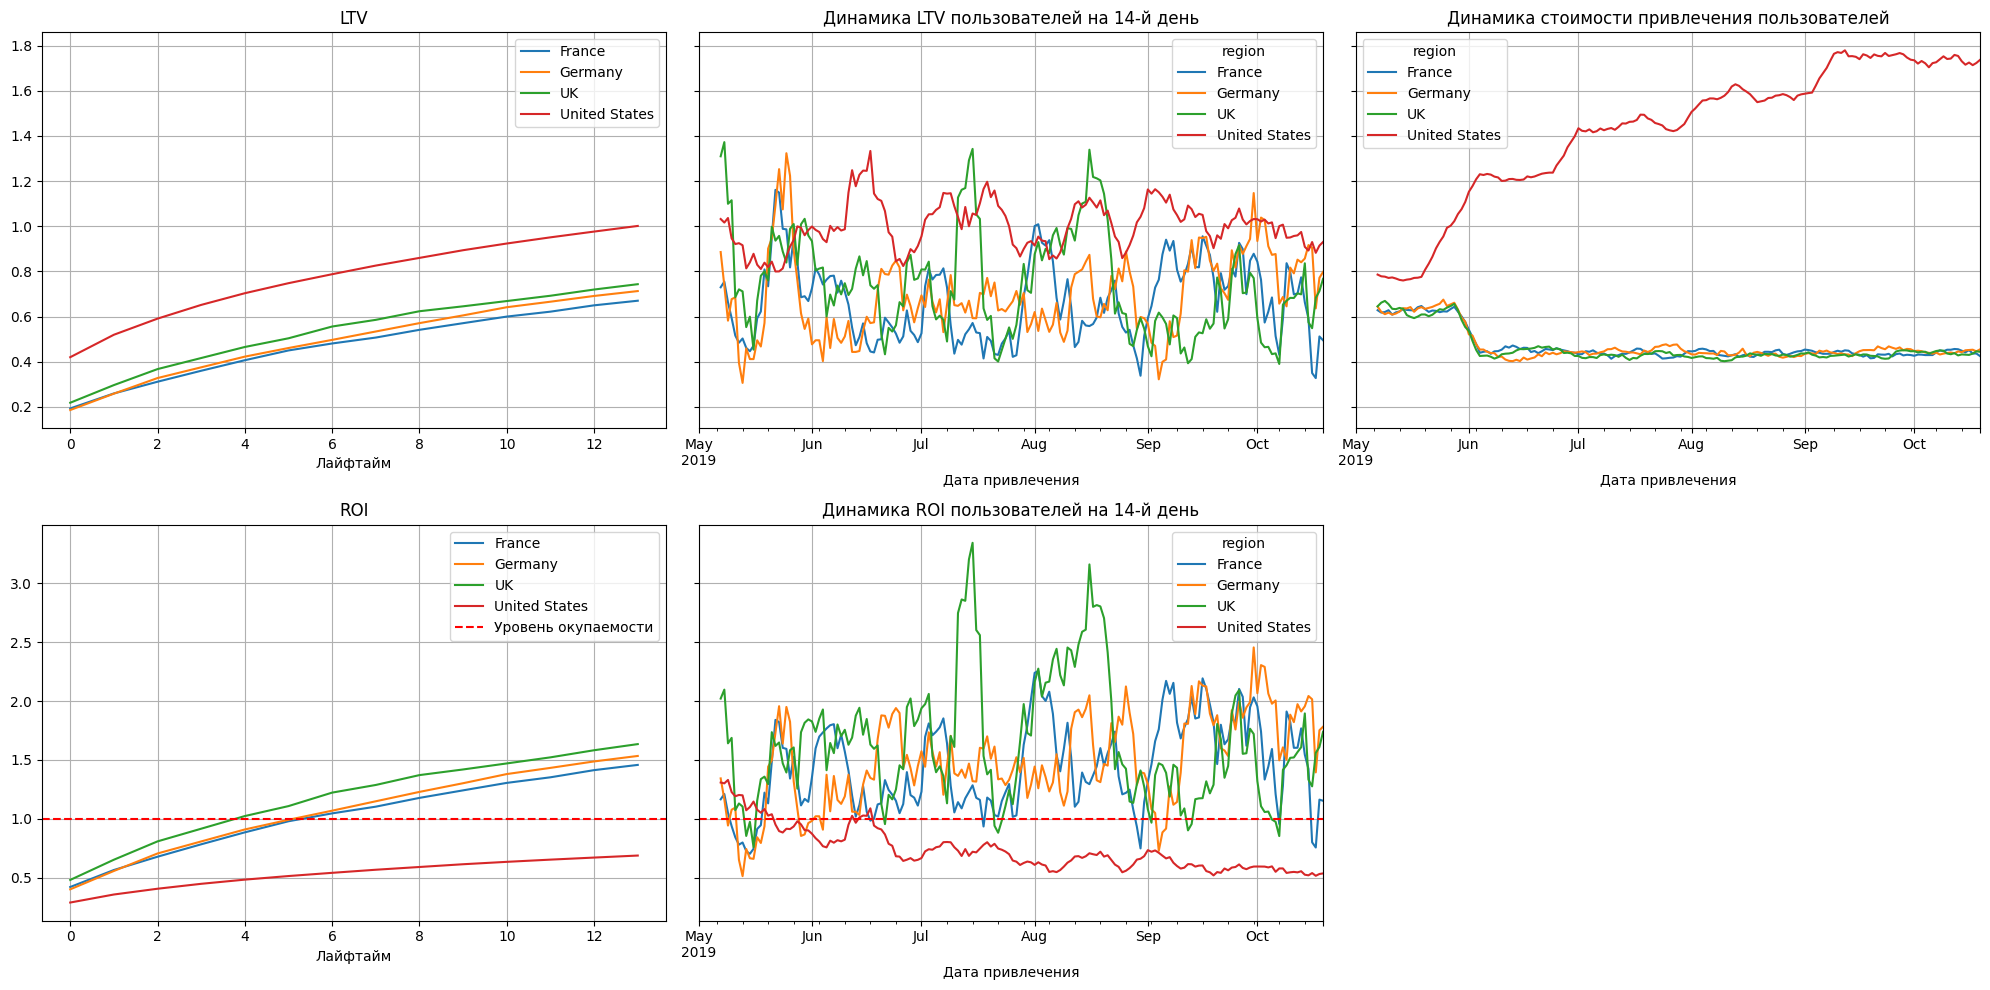

In [33]:
# вызываем функции с доп.параметром dimensions=['region']

ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles
    ,orders
    , observ_date
    , horizon_days
    , dimensions=['region']
)

# передаём данные функции отрисовки
plot_ltv_roi(
    ltv_grouped
    , ltv_in_time
    , roi_grouped
    , roi_in_time
    , horizon_days
    , window=7
)

Оценим окупаемость рекламы в разбивке по странам, откуда привлечены клиенты:
- судя по графику LTV, видим, что наибольшая пожизненная стоимость у пользователей из США;
- динамика LTV на 14 день неоднородна, но стабильна, США - также в лидерах;
- по динамике CAC видим, что средние расходы на привлчение пользователей в США растут "космическими" темпами с начала июня, прибавляя каждый месяц, средние расходы по остальным регионам, наоборот упали, держатся равномерно и стабильно низко;
- по графику ROI можно отметить, что пользователи всех регионов, кроме США, окупают расходы на своё привлечение уже 4-5 лайфтайму, пользователи из США не окупаются;
- динамика ROI на 14-ый день показывает, что за небольшим исключением, по всем когортам из разных стран (кроме США) пользователи окупают затраты на привлечение, ну, или находятся близко к 0. В тоже время, пользователи из США с когорт июня 2019 года в 14-ый день являются убыточными, приём динамика отрицательная - каждая новая когорта является убыточней прошлой - график нисходящий.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

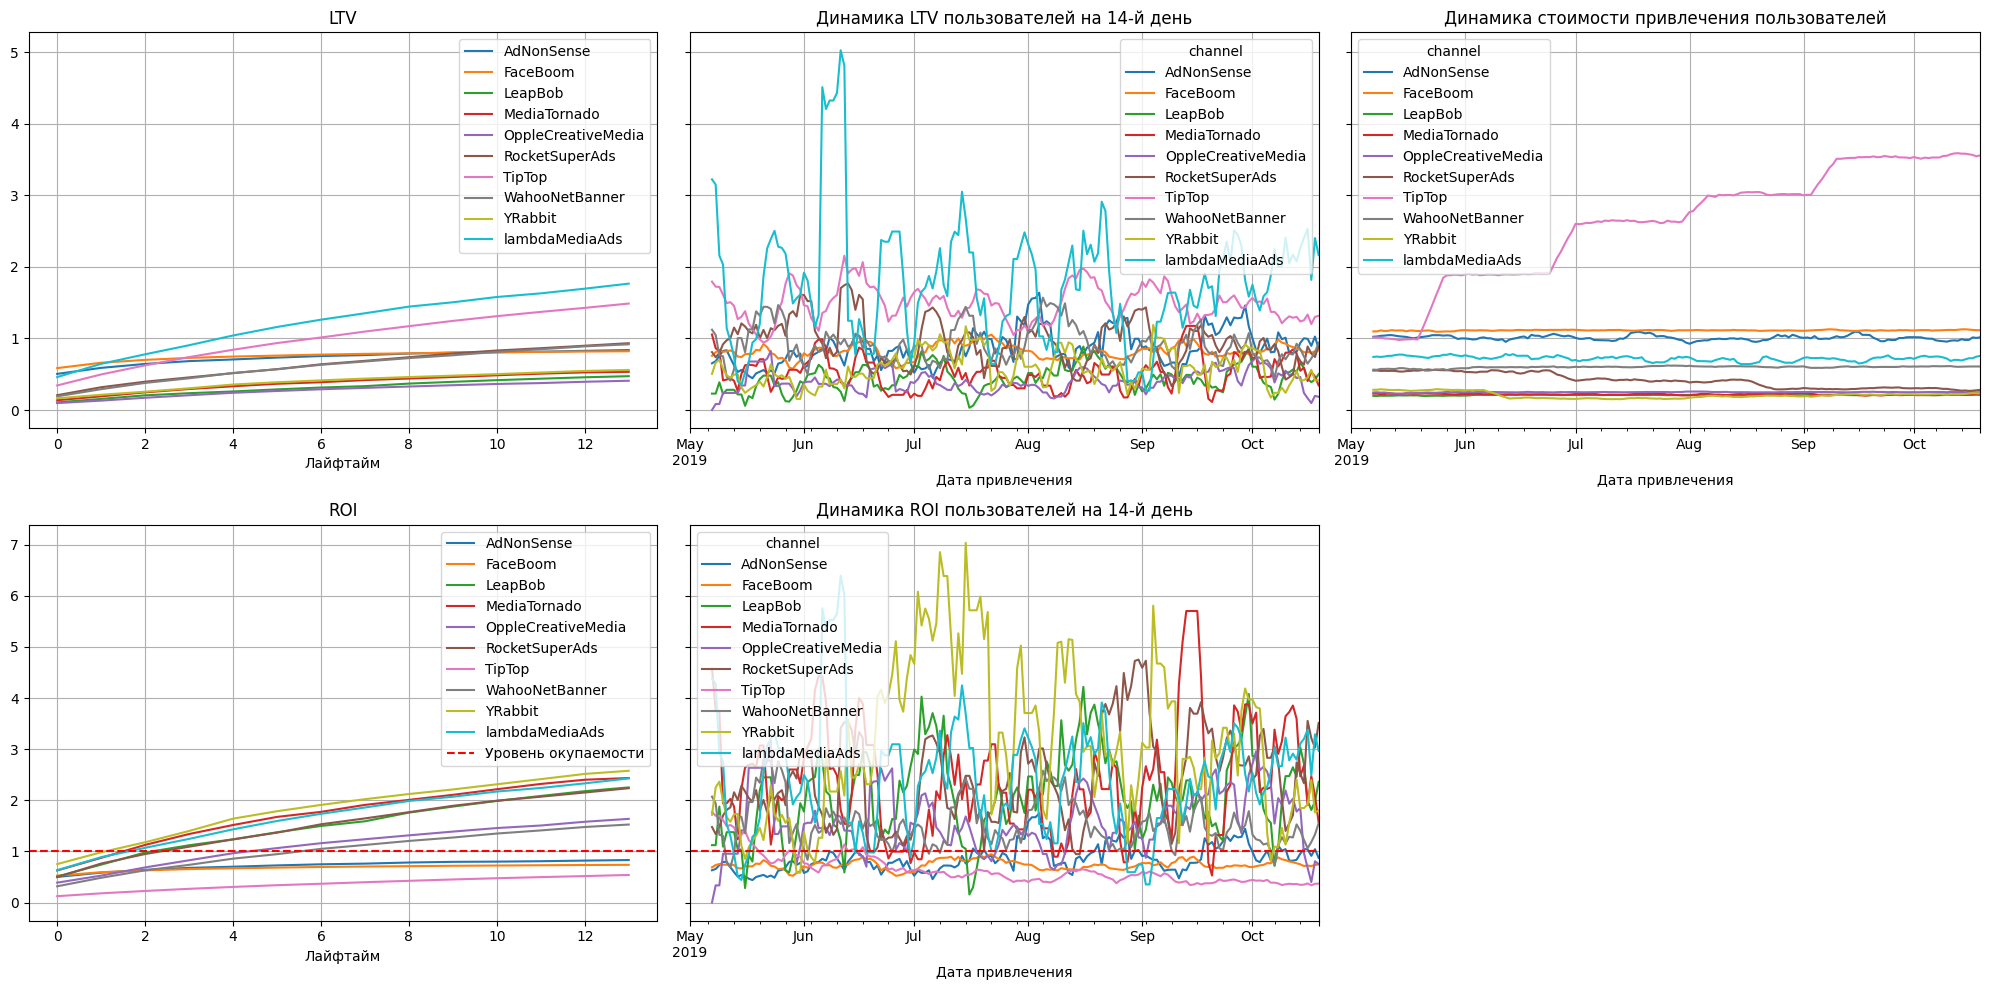

In [34]:
# вызываем функции с доп.параметром dimensions=['channel']

ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles
    ,orders
    , observ_date
    , horizon_days
    , dimensions=['channel']
)

# передаём данные функции отрисовки
plot_ltv_roi(
    ltv_grouped
    , ltv_in_time
    , roi_grouped
    , roi_in_time
    , horizon_days
    , window=7
)

Анализ графиков окупаемости рекламы по данным о пользователях в разбивке по каналам привлечения:
- пользователи, пришедшие с каналов lambdaMediaAds и TipTop, являются наиболее доходными; 
- на 14-ый день наибольший LTV также показывают пользователи с этих каналов;
- динамика CAC по каналу TipTop - выдающаяся во всех смыслах, заметен постоянный рост средней стоимости привлечения пользователей по этому каналу;
- график ROI неутешительно подсказывает, что пользователи с каналов lambdaMediaAds, TipTop и FaceBoom - не окупаются на 14 день! Соотношение доход/затраты - меньше единицы;
- динамика ROI подтверждает картину описанную выше - на 14 день лайфтайма в большинстве когорт для перечисленных каналов lambdaMediaAds, TipTop и FaceBoom пользователи являются убыточными.

<b> Промежуточный вывод</b>
<p>Таким образом, можно сделать вывод что рекламный отдел сделал ставку на пользователей из США и предпочитающих iPhone/Mac, которые являются основной платящей аудиторией приложения (2/3 всех платящих пользователей из США, больше трети платящих -  пользователи iPhone)
<p>Этих пользователей решено было привлекать через каналы TipTop и FaceBoom, затраты в остальные каналы - сведены до минимума, вся эта история началась в июне 2019 года. С каждым месяцем вложения в указанные каналы увеличивались, пользователей приходило тоже много, но недостаточно, чтобы отбить затраты на рекламу.

Посмотрим более внимательно на пользовательские характеристики (удержание и конверсию) с учётом промежуточного вывода.
<p>Сначала оценим удержание и конверсию с разбивкой по "региону"

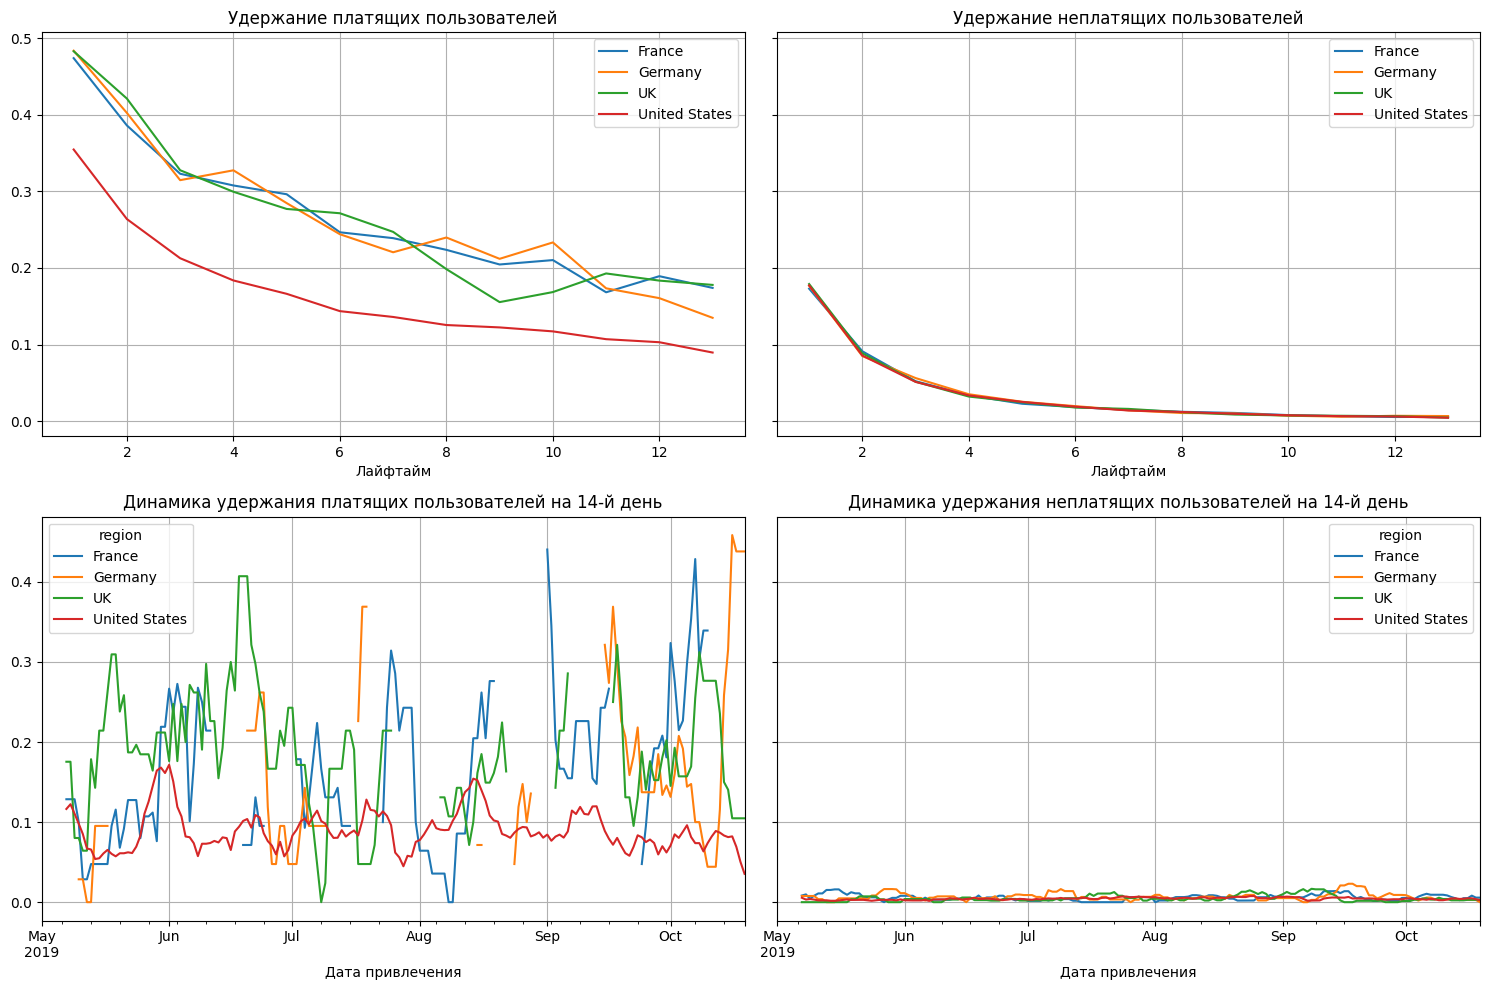

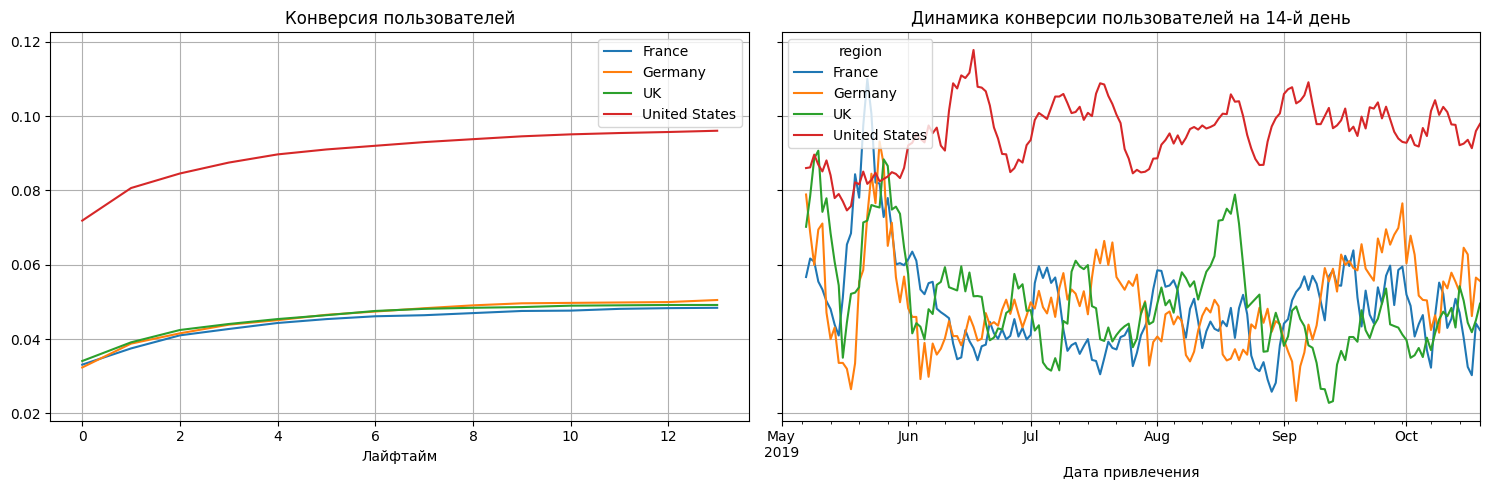

In [35]:
# вызываем get_retention и get_conversion c доп.парметром region

retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles, visits, observ_date, horizon_days, dimensions=['region']
)
coversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles, orders, observ_date, horizon_days, dimensions=['region']
)

# передаём данные функции отрисовки
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

Пользователи из США прекрасно конвертируются - в два раза лучше остальных регионов! Но вот удержание "хромает": на 14 день конвертируется около 5%, в то время, как у пользователей из других стран, этот показатель может достигать 40%!<br>
<p>Посмотрим на удержание и конверсию пользователей в разрезе "каналов привлечения": в первую очередь нас интересуют TipTop и FaceBoom, на которых сдалана ставка рекламным отделом.

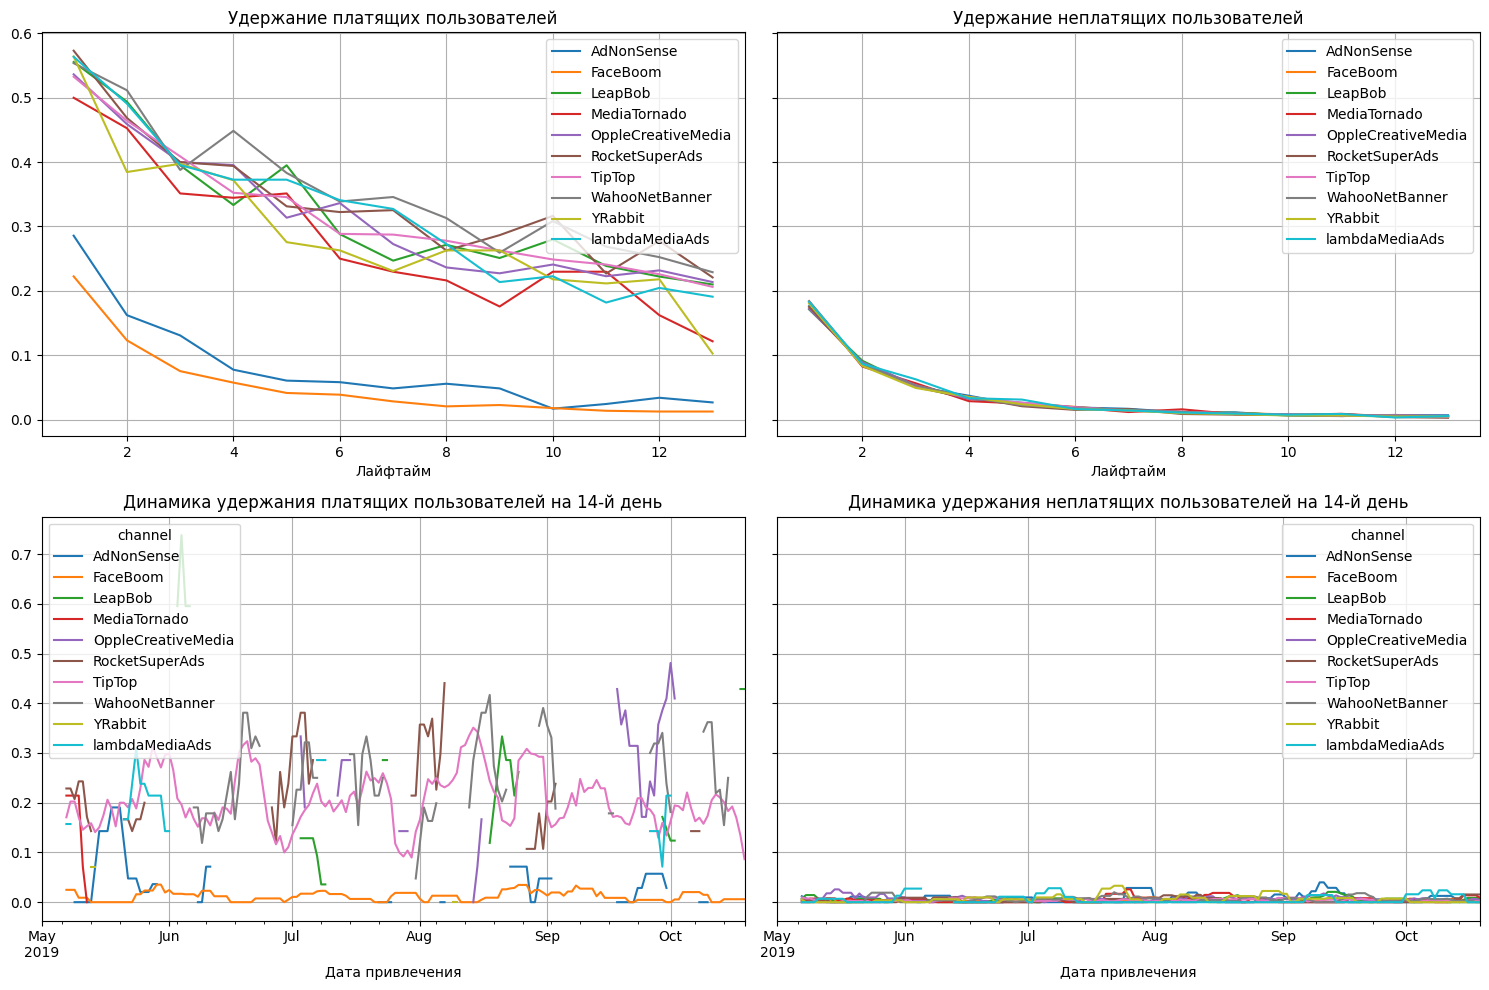

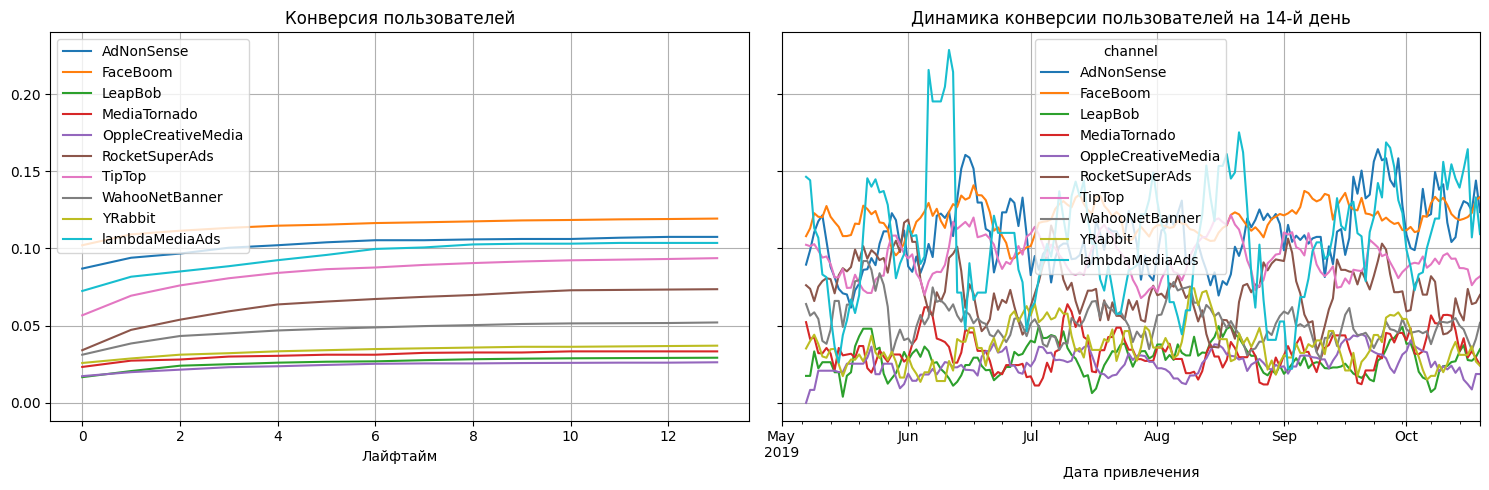

In [36]:
# вызываем get_retention и get_conversion c доп.парметром channel

retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles, visits, observ_date, horizon_days, dimensions=['channel']
)
coversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles, orders, observ_date, horizon_days, dimensions=['channel']
)

# передаём данные функции отрисовки
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

Пользователи, пришедшие через FaceBoom - лидеры по конверсии, но очень плохо удерживаются! К 14 дню конвертируется около 1% - очень низкий показатель, особенно на фоне других платформ. Пользователи от TipTop держатся "середнячком" - как по удержанию, так и по конверсии.<br><br>

<p>Проверим гипотезу о ставке рекламного отдела на пользователей из США: посмотрим, пользователи из каких стран приходят через эти каналы:

In [37]:
profiles.query('channel=="FaceBoom" or channel=="TipTop"')['region'].value_counts()

United States    48705
Name: region, dtype: int64

100% попадание в США.<br>
<p>Также оценим предпочитаемые ими устройства:

In [38]:
profiles.query('channel=="FaceBoom" or channel=="TipTop"')['device'].value_counts()

iPhone     21836
Mac        12085
Android     9764
PC          5020
Name: device, dtype: int64

Здесь тоже догадка верна - преобладающие устройства пользователей, привлекаемых этими каналами, - iPhone и Mac.

## Выводы и рекомендации

В ходе анализа были изучены данные о пользователях приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года: данные о посещениях пользователями из разных стран, их покупках. Допольнительно использовались данные о расходах на рекламу с разбивкой по периодам.
<p>Основная задача - выявление причин (факторов) убыточности по итогам указанного промежутка времени.<br><br>
<p>В ходе работы были составлены профили пользователей для выяснения их первичного визита, предпочитаемого устройства и региона, также эти данные были сопоставлены с данными о проводимых рекламных кампаниях. Приход новых пользователей ассоциировался с проводимыми на тот момент рекламными акциями с целью выявления источника привлечения, что также было отражено в профилях пользователей.
<p>Основной упор делался на выявлении характеристик платящих пользователей, как потенциальный источник прибыли компании.
<p>На основе данных пользователей были определены:
<li>страны с наибольшей долей платящих пользователей (2/3 от всех пользователей из США, платящих из них около 7%);
<li>предпочитаемые платящими пользователями устройства (лидеры - iPhone и Mac с показателями больше 6% при общем количестве пользователей 56% на пару, у остальных доля платящих в районе 4%);
<li>рейтинг каналов привлечения платящих пользователей (FaceBoom, AdNonSense, lambdaMediaAds, TipTop - доли платящих от 9,5 до 12,5% от общего трафика, лидеры по общему привлекаемому трафику TipTop и FaceBoom).<br>
<p>Следующим этапом исследования было составление рейтинга каналов по затратам за весь период. Абсолютный лидер: TipTop (больше 50% бюджета), на втором месте FaceBoom (больше 30% бюджета). Эти же каналы заняли первые два места по средней стоимости привлечения клиентов (CAC).
<p>Общий анализ окупаемости привлекаемых пользователей показал, что вложения в рекламу не окупаются приносимыми доходами от новых клиентов. Доходы от пользователей, пришедших после июня 2019 года, не могут "отбить" все расходы на их привлечение - это <b>основная причина убыточности.</b>
<p>Анализ динамики расходов на рекламу показал, что компания с июня 2019 год планомерно повышала расходы (инвестировала) на каналы TipTop и FaceBoom, делая ставку на самых доходных (высокий LTV) и хорошо конвертирующихся клиентов из США (в основном предпочитающим iPhone).<br>Однако темп роста этих инвестиций не был обеспечен соотвествующим притоком платящих ползователей, к тому же, большая часть пользователей (пришедших по каналу FaceBoom) показывало низкий коэффициент удержания.
<p>Отдел маркетинга принял верное решение, больше привлекать качественных и платящих пользователей, правильно выбрал канал привлечения, но при составлении инвестиционного плана не учитывались оперативные метрики CAC и ROI. Полагаю, решение по наращиванию рекламных расходов при отсутствии соответствующей отдачи, в виде прихода новых пользователей, явилось главной ошибкой.
<p>Вероятно, имеет смысл рассмотреть "портфельное" инвестирование, выбрав разные каналы, не делая упор на 1 или 2: хорошие показатели LTV имеют пользователи, пришедшие и по другим каналам.
<p>Необходимо продумать методы повышения коэффициента удержания платящих пользователей (дополнительные бонусы, коммуникации и т.п.)<br>
<p>Как вариант, при таком агрессивном плане инвестиций, можно, по возможности, расмотреть изменение параметров бизнес-плана, давая пользователям больше времени на то, чтобы окупить рекламные расходы, так, при горизонте анализа больше 23 дней рекламные расходы начинают отбиваться.